In [285]:
import pymc as pm
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Vocabulary for indexing word values

In [286]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

class Vocabulary():
    def __init__(self,base,files):
        self.files = files
        self.base = base
        self.words = None
        self.vocab_idx = {}
        self.idx_vocab = {}
    def read_files(self):
        lemmatizer = WordNetLemmatizer()
        documents_list = []
        words = []
        for x in self.files:
            sentence_list = []
            file = open(self.base+"/"+x,"r")
            for y in file.readlines():
                word_list = []
                y = y.replace('\n', "")
                y = y.lower()
                y = y.translate(str.maketrans('', '', string.punctuation))
                y = y.split(' ')
                for word in y:
                    if word == '' or word in stopwords.words('english'):
                        pass
                    else:
                        word = lemmatizer.lemmatize(word)
                        sentence_list.append(word)
                        if word not in words:
                            words.append(word)
            documents_list.append(sentence_list)
        self.vocab_idx = {x:idx for idx,x in enumerate(words)}
        self.idx_vocab = {idx:x for idx,x in enumerate(words)}
        return documents_list
    def word_to_idx(self,x):
        temp = []
        for word in x:
            temp.append(self.vocab_idx[word])
        return temp
    def idx_to_word(self, x):
        temp = []
        for word in x:
            temp.append(self.idx_vocab[word])
        return temp
    def __len__(self):
        return len(self.vocab_idx)
    def build_vocab(self,x):
        word_list = []
        for sent in x:
            for word in sent:
                if word not in word_list:
                    word_list.append(word)
        self.vocab_idx = {x: idx for idx, x in enumerate(word_list)}
        self.idx_vocab = {idx: x for idx, x in enumerate(word_list)}

In [287]:
vocab = Vocabulary("./text",os.listdir("./text"))
documents = vocab.read_files()
distr_list = []
value_list = []
for x in documents:
    v = np.array(vocab.word_to_idx(x))
    value_list.append(v)
    distr = np.zeros(len(vocab))
    for value in v:
        distr[value]+=1
    distr_list.append(distr) # word distibution

In [302]:
documents[1][:5] # Words for test

['suddenly', 'shadow', 'pass', 'across', 'bilbofor']

In [305]:
distr_list[1][:5] # Words distribution, in this proposition the word with the index 0 appers 4 times

array([ 4.,  0.,  0.,  0.,  6.])

In [306]:
value_list[1][:5]# Words index encoding

array([ 85, 137, 138, 139, 140])

#### M -> Number of documents 
#### K -> Number of topics

In [289]:
M = len(documents)
K = 2

###### Using Dirichlet values to have a vector or probabilities to sum up to 1
Theta is topic probability for documents  
Phi is word probability to belong to topic

In [290]:
theta = pm.Container([pm.CompletedDirichlet("theta_%s" % i, pm.Dirichlet("p-theta_%s" % i, theta=np.ones(K))) for i in range(M)])
phi = pm.Container([pm.CompletedDirichlet("phi_%s" % i, pm.Dirichlet("p-phi_%s" % i, theta=np.ones(len(vocab)))) for i in range(K)])

In [291]:
Wd = [doc.shape[0] for doc in value_list]
distr_list = np.array(distr_list)
value_list = np.array(value_list)

We create the Z vector for word with index belonging to the topic  
And a W to calculate for each document and each word its belonging

In [292]:
z = pm.Container([pm.Categorical('z_%i' % d,
                     p = theta[d],
                     size=Wd[d],
                     value=np.random.randint(K, size=Wd[d]))
                  for d in range(value_list.shape[0])])
w = pm.Container([pm.Categorical("w_%i_%i" % (d,i),
                    p = pm.Lambda('phi_z_%i_%i' % (d,i),
                              lambda z=z[d][i], phi=phi: phi[z]),
                    value=value_list[d][i],observed=True)
                  for d in range(value_list.shape[0]) for i in range(Wd[d])])

In [293]:
import matplotlib.pyplot as plt

# For the input example we have 
docs = [["aaa", "bbb", "aaa"],
["bbb", "aaa", "bbb"],
["aaa", "bbb", "bbb", "aaa"],
["uuu", "vvv"],
["uuu", "vvv", "vvv"],
["uuu", "vvv", "vvv", "uuu"]]


 [-----------------100%-----------------] 10000 of 10000 complete in 14.3 sec
 Word probability distribution per topic
0
[ 0.38147937  0.35379281  0.11347622  0.1512516 ]


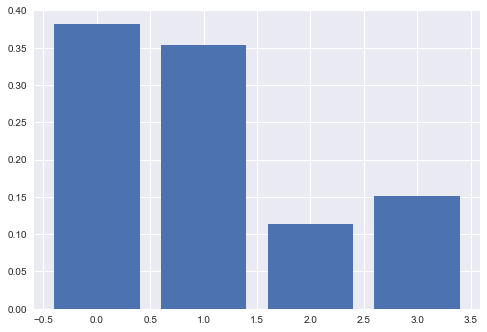

1
[ 0.17685225  0.22217844  0.28856782  0.31240149]


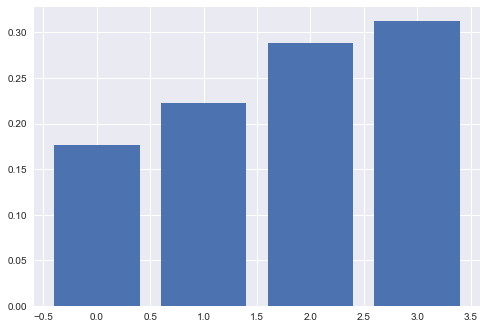

Document probability distribution per topic
0
[[ 0.56089802  0.43910198]]


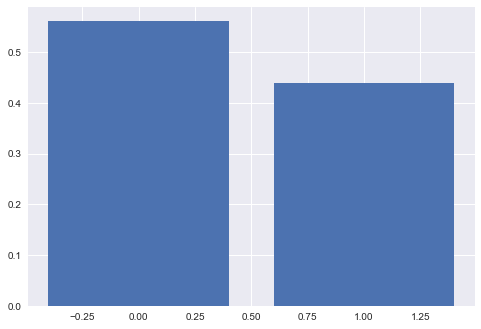

1
[[ 0.52384573  0.47615427]]


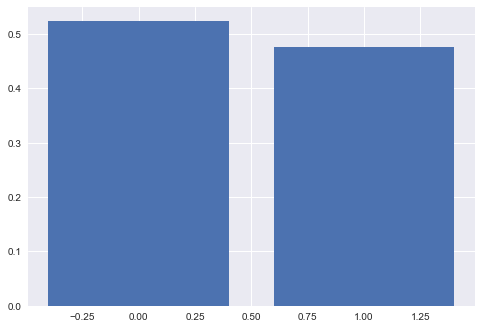

2
[[ 0.51363091  0.48636909]]


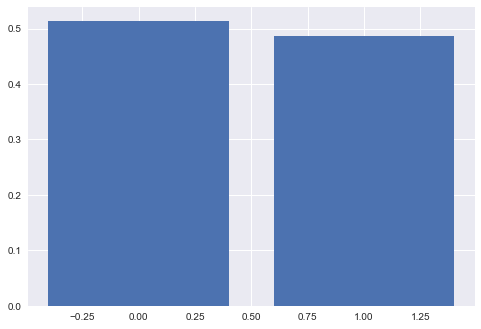

3
[[ 0.35576988  0.64423012]]


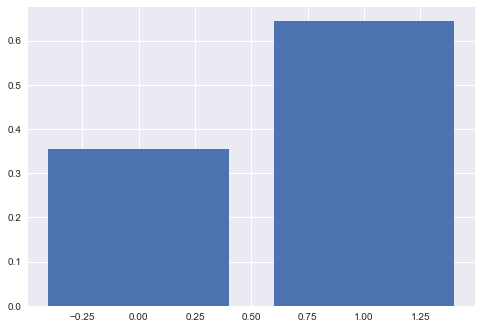

4
[[ 0.30529637  0.69470363]]


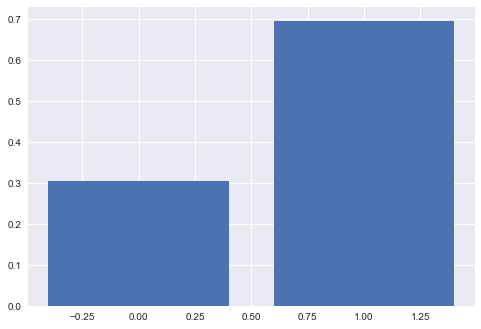

5
[[ 0.23194418  0.76805582]]


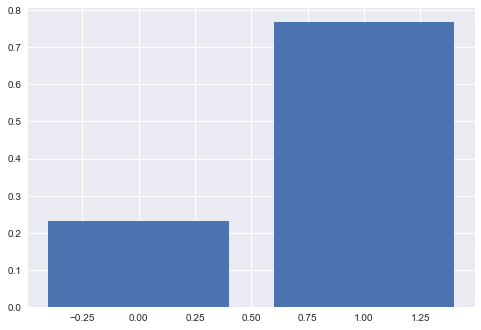

[0 0 0]
[0 0 0]
[0 0 0 0]
[1 1]
[1 1 1]
[1 1 1 1]


In [50]:
model = pm.Model([theta, phi, z, w])
mcmc = pm.MCMC(model)
mcmc.sample(10000, 8000, 1)
print("\n Word probability distribution per topic")
for i in range(K):
    print(i)
    t =mcmc.trace("phi_" + str(i))[:]
    labels =  np.arange(0,len(t.mean(axis=0)[0]))
    print(t.mean(axis=0)[0])
    plt.bar(labels,t.mean(axis=0)[0])
    plt.show()
print("Document probability distribution per topic")    
for i in range(M):
    print(i)
    t =mcmc.trace("theta_" + str(i))[:]
    print(t.mean(axis=0))
    labels =  np.arange(0,len(t.mean(axis=0)[0]))
    plt.bar(labels,t.mean(axis=0)[0])
    plt.show()
for i in range(M):
    values = z[i].value
    print(values)
    labels =  np.arange(0,len(values))

##### We use hellringer distance to calculate document similarity for word probability  

In [60]:
from gensim.matutils import hellinger
hellinger(phi[0].value,phi[1].value)

0.71331093925881628

We are going to use 8 documents with film transcript from Lord of the Rings and Star Wars and see if we can have a good distribution for topics

 [-----------------100%-----------------] 1000 of 1000 complete in 10.5 sec
 Word probability distribution per topic
0
1
Document probability distribution per topic
0
[[ 0.5549748  0.4450252]]


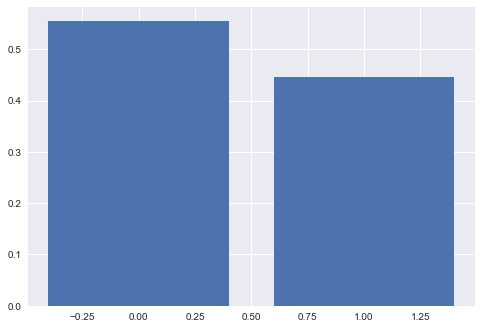

1
[[ 0.45010319  0.54989681]]


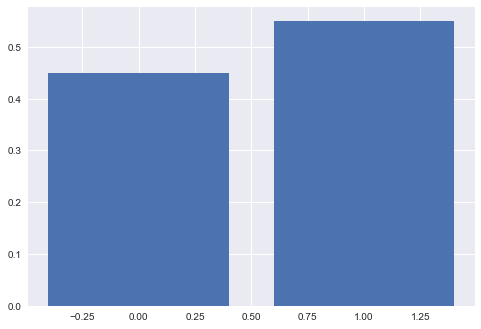

2
[[ 0.43064624  0.56935376]]


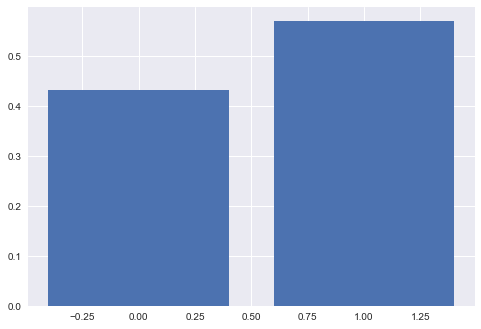

3
[[ 0.43069251  0.56930749]]


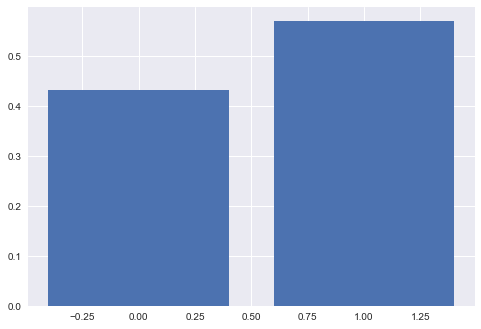

4
[[ 0.5202699  0.4797301]]


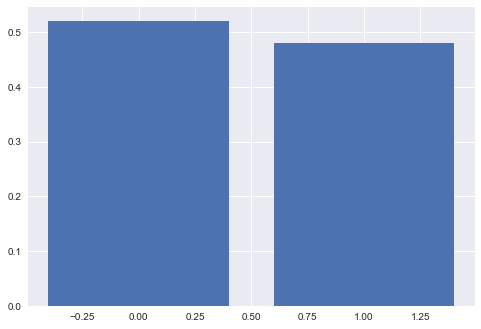

5
[[ 0.51127241  0.48872759]]


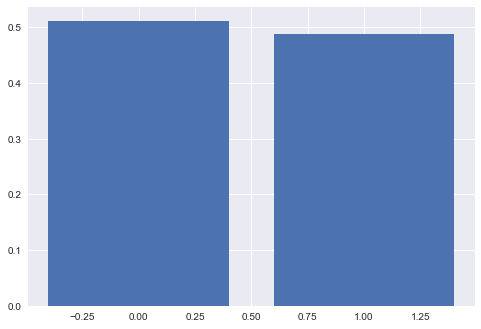

6
[[ 0.55703688  0.44296312]]


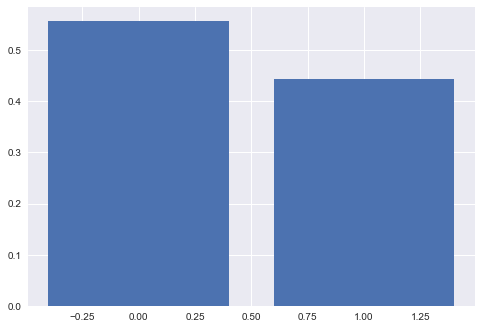

7
[[ 0.45259277  0.54740723]]


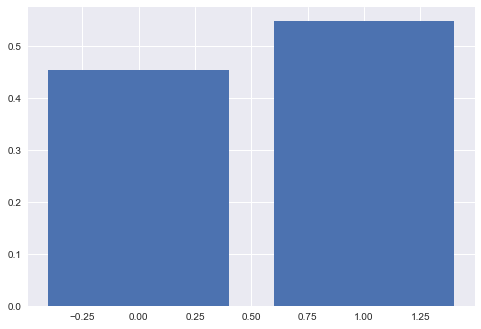

[0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0
 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0
 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 0 0 1 1 0 0 1 0
 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0
 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 1
 0 1 0 0 0 1 0 0 1 0 1 1 0]
[1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 1 1
 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 0 0 1
 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 1
 0 1 1 0 0 0 1 0 0 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0
 0 1 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 0
 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0
 1 0 0 1 1 1 0 0]
[1 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 1
 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1

In [295]:
model = pm.Model([theta, phi, z, w])
mcmc = pm.MCMC(model)
mcmc.sample(1000, 100, 1)
print("\n Word probability distribution per topic")
for i in range(K):
    print(i)
    t =mcmc.trace("phi_" + str(i))[:]
    #labels =  np.arange(0,len(t.mean(axis=0)[0]))
    #print(t.mean(axis=0)[0])
    #plt.bar(labels,t.mean(axis=0)[0])
    #plt.show()
print("Document probability distribution per topic")    
for i in range(M):
    print(i)
    t =mcmc.trace("theta_" + str(i))[:]
    print(t.mean(axis=0))
    labels =  np.arange(0,len(t.mean(axis=0)[0]))
    plt.bar(labels,t.mean(axis=0)[0])
    plt.show()
for i in range(M):
    values = z[i].value
    print(values)
    labels =  np.arange(0,len(values))

In [296]:
from gensim.matutils import hellinger
hellinger(phi[0].value,phi[1].value)

0.47208149773613106

In [297]:
topic_index = []
for i in range(K):
    topic_index.append([])
for i in range(M):
    values = z[i].value
    for j in range(K):
        topics = []
        val = j == values
        val = value_list[i][val]
        for l in val:
            topic_index[j].append(int(l))

In [298]:
from collections import Counter
import collections

In [299]:
for i in range(K):
    #print(sorted(topic_index[i]))
    topic_index[i] = Counter(topic_index[i]).most_common(25)

Here we have 25 the most common word per topic

In [307]:
for i in range(K):
    temp = []
    for y in topic_index[i]:
        temp.append(y[0])
    print(vocab.idx_to_word(temp))

['int', 'gandalf', 'luke', 'red', 'star', 'death', 'ext', 'cockpit', 'frodo', 'around', 'fighter', 'leader', 'boromir', 'continued', 'rebel', 'gimli', 'voice', 'fellowship', 'make', 'main', 'threepio', 'xwing', 'u', 'turn', 'look']
['luke', 'int', 'death', 'leader', 'boromir', 'star', 'red', 'cockpit', 'look', 'fellowship', 'legolas', 'aragorn', 'ext', 'xwing', 'gimli', 'frodo', 'close', 'back', 'rebel', 'leia', 'fighter', 'long', 'gandalf', 'eye', 'must']


Some words appear in both, but we can see that they contain also unique words specific for the topics

In conclusion for Task 2
We can use topic modeling for text similarity by using Hellringer distance for the word probability per topic  
Also for new documents that we have we can use Gibs Sampling by adding the new words to the corpus and correlate to the most similar values, keeping the old documents topic the same.  
Gibs sampling is a MCMC model and is going to be applied only to the new words giving values by correlating to the previous results of the MCMC model and keep the previous data the same.